# Tutorial 2 - Feature selection and extraction

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_openml, load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, normalize
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn import decomposition
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import imgaug.augmenters as iam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Zadanie 1. Selekcja cech

*Opisać najważniejsze procedury selekcji cech. Jako przykład przedstawić działanie odpowiednich procedur scikit-learn eliminujących cechy na podstawie wybranego zbioru UCI dataset (np. Wisconsin_cancer, i jeszcze jakiś jeden inny, nie zapomnieć o normalizacji). Przedstawić uporządkowany histogram wag poszczególnych cech.*

### Filter methods

Filtry polegają na zdefiniowaniu metryki, a następnie obliczeniu jej dla wszystkich cech i wyborze najlepszych z nich. Przykładowe algorytmy:


*   Chi-squared
*   Pearson`s correlation
*   Variance threshhold


### Wrapper methods


Metody opakowane używają dodatkowego algorytmu uczenia maszynowego jako kryterium doboru podzbioru cech. Wybierany jest ten podzbiór, który daje najlepsze wyniki przy użyciu zastosowanego algorytmu.
Przykłady:


*   Forward selection
*   Recursive feature elimination



### Embedded methods
Metody wbudowane wykorzystują algorytmy posiadające wbudowane sposoby selekcji cech. Przykłady:

*   Lasso regression
*   Ridge regression




### Przykłady zastosowania

In [0]:
def print_selected_features(mask_arr, features):
  print("best features: ")
  for i, mask in enumerate(mask_arr):
    if mask:
      print("[%d] %s" % (i, features[i]))


def selectKbest_selection(X_train, y_train, m_best, features):
  selector = SelectKBest(chi2, k = m_best)
  selector.fit(X_train, y_train)

  print_selected_features(selector.get_support(), features)


def rfe_selection(X_train, y_train, m_best, features):
  estimator = ExtraTreesClassifier() # algorithm used to estimate relevance for each feature
  selector = RFE(estimator, m_best)
  selector.fit(X_train, y_train)

  print_selected_features(selector.get_support(), features)

In [0]:
# breast cancer dataset
wisconsin = load_breast_cancer()
features = wisconsin.feature_names
print("all features: ")
print(features)

X, y = load_breast_cancer(return_X_y=True)
Xnorm = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.2)

m_best = 5
print("\nSelectKBest: ")
selectKbest_selection(X_train, y_train, m_best, wisconsin.feature_names)
print("\nRFE: ")
rfe_selection(X_train, y_train, m_best, wisconsin.feature_names)

all features: 
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

SelectKBest: 
best features: 
[1] mean texture
[2] mean perimeter
[3] mean area
[21] worst texture
[22] worst perimeter

RFE: 
best features: 
[0] mean radius
[2] mean perimeter
[3] mean area
[20] worst radius
[22] worst perimeter


In [0]:
# iris dataset
iris = load_iris()
features = iris.feature_names
print("all features: ")
print(features)

X, y = load_iris(return_X_y=True)
Xnorm = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.2)

m_best = 3
print("SelectKBest: ")
selectKbest_selection(X_train, y_train, m_best, iris.feature_names)
print("\nRFE: ")
rfe_selection(X_train, y_train, m_best, iris.feature_names)

all features: 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
SelectKBest: 
best features: 
[1] sepal width (cm)
[2] petal length (cm)
[3] petal width (cm)

RFE: 
best features: 
[1] sepal width (cm)
[2] petal length (cm)
[3] petal width (cm)


### Histogramy wag poszczególnych cech

In [0]:
def plot_feature_relevance(data, target, features_names):
  model = ExtraTreesClassifier()
  model.fit(data, target)
  ys = model.feature_importances_

  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1, 1])
  ax.bar(features_names, ys)
  plt.xticks(rotation=90)
  plt.show()

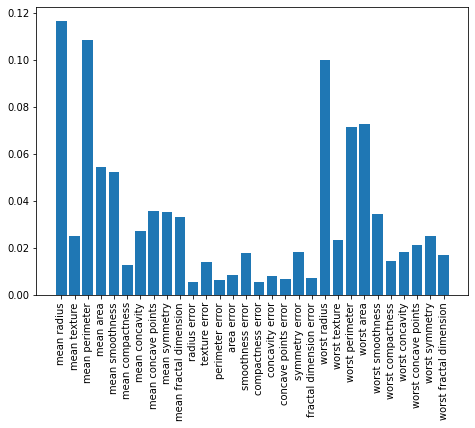

In [0]:
# breast cancer
wisconsin = load_breast_cancer()

plot_feature_relevance(normalize(wisconsin.data), wisconsin.target, wisconsin.feature_names)

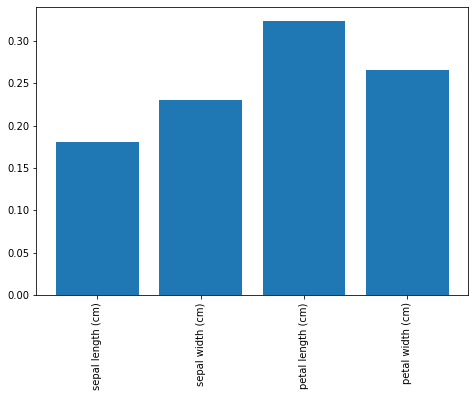

In [0]:
# iris
iris = load_iris()

plot_feature_relevance(normalize(iris.data), iris.target, iris.feature_names)

## Zadanie 2. KNN
*Zbadać jakość klasyfikatorów k-nn (dla różnego k=1,3,5)  dla pełnego zestawu N cech, dla mniejszego zestawu m cech wybranych w sposób losowy  i dla wyselekcjonowanego  zestawu m najlepszych cech. Przy pomocy studentów wypełnić tabelkę: (k=1,3,5; m=N,5,2) dla tych dwóch zbiorów.*

In [0]:
# Utility functions
def predict_and_check_util(k, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

  knn = KNeighborsClassifier(n_neighbors=k) 
  knn.fit(X_train, y_train)
  y_predict = knn.predict(X_test)

  return accuracy_score(y_test, y_predict)

def predict_and_check_best(k, m, X, y):
  X_new = SelectKBest(chi2, k=m).fit_transform(X, y)

  acc = predict_and_check_util(k, X_new, y)
  return acc

def predict_and_check_random(k, m, X, y):
  X_new = X[:, :m]

  acc = predict_and_check_util(k, X_new, y)
  return acc


# k values used in k-nn
ks = [1, 3, 5]

In [0]:
data, target = load_breast_cancer(return_X_y=True)
X, y = data.copy(), target.copy()

In [0]:
# wisconsin dataset:
features_count = X.shape[1]
ms = [features_count, 5, 2]

acc_best = []
acc_random = []

for k in ks:
  for m in ms:
    acc_best.append([k, m, predict_and_check_best(k, m, X, y)])
    acc_random.append([k, m, predict_and_check_random(k, m, X, y)])

df = pd.DataFrame(acc_best, columns=['k-neighbours', 'm-best', 'score'])
print('Best scores:')
print(df)
print()

df = pd.DataFrame(acc_random, columns=['k-neighbours', 'm-best', 'score'])
print('Random scores:')
print(df)


Best scores:
   k-neighbours  m-best     score
0             1      30  0.916667
1             1       5  0.901316
2             1       2  0.864035
3             3      30  0.916667
4             3       5  0.932018
5             3       2  0.925439
6             5      30  0.925439
7             5       5  0.932018
8             5       2  0.918860

Random scores:
   k-neighbours  m-best     score
0             1      30  0.925439
1             1       5  0.824561
2             1       2  0.850877
3             3      30  0.918860
4             3       5  0.864035
5             3       2  0.857456
6             5      30  0.903509
7             5       5  0.769737
8             5       2  0.872807


In [0]:
data, target = load_iris(return_X_y=True)
X, y = data.copy(), target.copy()

In [0]:
# iris dataset:
features_count = X.shape[1]
ms = [features_count, 3, 2]

acc_best = []
acc_random = []

for k in ks:
  for m in ms:
    acc_best.append([k, m, predict_and_check_best(k, m, X, y)])
    acc_random.append([k, m, predict_and_check_random(k, m, X, y)])

df = pd.DataFrame(acc_best, columns=['k-neighbours', 'm-best', 'score'])
print('Best scores:')
print(df)
print()

df = pd.DataFrame(acc_random, columns=['k-neighbours', 'm-best', 'score'])
print('Random scores:')
print(df)

Best scores:
   k-neighbours  m-best     score
0             1       4  0.858333
1             1       3  0.966667
2             1       2  0.925000
3             3       4  0.841667
4             3       3  0.933333
5             3       2  0.975000
6             5       4  0.958333
7             5       3  0.941667
8             5       2  0.933333

Random scores:
   k-neighbours  m-best     score
0             1       4  0.925000
1             1       3  0.941667
2             1       2  0.633333
3             3       4  0.925000
4             3       3  0.858333
5             3       2  0.783333
6             5       4  0.950000
7             5       3  0.791667
8             5       2  0.708333


## Zadanie 3. Kowariancja
*Opisac Pythonową procedurę liczenia macierzy kowariancji. Pokazać, jak tworzy się „hot map” dla takiej macierzy. Co można z niej odczytać.*

Kowariancja określa zależność liniową między dwiema zmiennymi. Dodatnia kowariancja oznacza, że wartości dwóch zmiennych zachowują sie wprost proporcjonalnie. Ujemna - odwrotnie proporcjonalnie, a bliska zeru: że zmienne nie są ze sobą powiązane. W macierzy kowariancji, `Cov[i][j]` oznacza kowariancję zmiennych `i` oraz `j`.

      a      b     c     d
a  4.50   8.50  -4.5  0.25
b  8.50  19.30 -10.9  0.45
c -4.50 -10.90   6.7 -0.10
d  0.25   0.45  -0.1  0.30



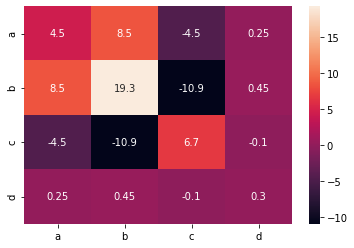

In [0]:
data = {
    'a': [2, 4, 7, 5, 2],
    'b': [1, 5, 12, 10, 5],
    'c': [10, 7, 3, 5, 6],
    'd': [0, 1, 0, 1, 0]
}

df = pd.DataFrame(data,columns=['a','b','c', 'd'])

covMatrix = pd.DataFrame.cov(df)

print(covMatrix)
print()

sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

## Zadanie 4. PCA
*Opisać działanie transformacji PCA. Opisać Pythonowe procedury realizujące transformatę PCA.  Pokazać jak wybierane są nowe cechy, kombinacją jakich oryginalnych cech są nowe cechy. Przedstawić (podobnie jak w przypadku selekcji cech) uporządkowany histogram wag (wartości własnych) poszczególnych nowych cech. Porównać do tego, stworzonego wcześniej, dla oryginalnych cech*

### Transformacja PCA

#### Po co?
Częstym problemem w metodach uczenia maszynowego jest przekleństwo wymiarowości. Przy pomocy transformacji PCA można zredukować wymiarowość zbioru.

Często, gdy mamy wiele cech, spora część z nich jest ze sobą skorelowana. Zadaniem PCA jest odkrycie, które z cech są ze sobą skorelowane i w związku z tym, które można by zastąpić kombinacją liniową innych cech.

#### Zasada działania PCA
Zbiór z N cechami można interpretować jako N-wymiarowy układ współrzędnych.
Algorytm PCA oblicza w zestawie kowariancję pomiędzy cechami i szuka takiego obrotu tego układu współrzędnych, żeby pierwsza współrzędna miała największa wariancję, druga mniejszą, itd. Współrzędna przed obrotem jest daną cechą, a po obrocie kombinacją liniową starych cech. Każda kolejna współrzędna (nowa cecha po zastosowaniu PCA) ma mniejszy wpływ na dane.

Dzięki takiemu obrotowi układu, można odciąć cechy mające mniejszy wpływ na wynik.

*Obrazkowo:*

![PCA](https://hackernoon.com/drafts/kk19133no.png)

_https://hackernoon.com/dimensionality-reduction-using-pca-a-comprehensive-hands-on-primer-ph8436lj_


Załadujmy zbiór danych dotyczący raka piersi.

In [0]:
breast_cancer_ds = load_breast_cancer()

In [0]:
data = breast_cancer_ds['data'].copy()

print('Breast cancer data shape: ', data.shape)
normalized = normalize(data) # normalization is an important preprocessing step in PCA

Breast cancer data shape:  (569, 30)


Przypomnijmy sobie wykres wag starych cech:

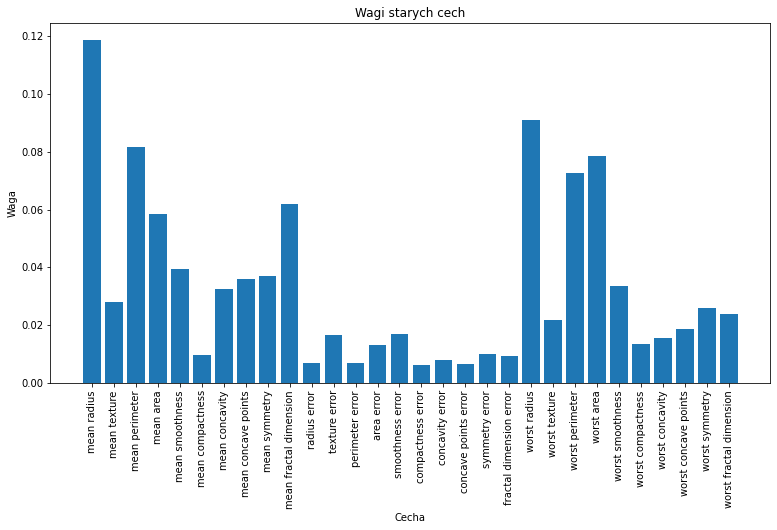

In [0]:
# feature importance
model = ExtraTreesClassifier()
model.fit(normalized, breast_cancer_ds['target'])

xs = breast_cancer_ds.feature_names
ys = model.feature_importances_

# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(xs, ys)
plt.xticks(rotation=90)
plt.title("Wagi starych cech")
plt.ylabel("Waga")
plt.xlabel("Cecha")
plt.show()

Zaaplikujmy PCA

In [0]:
def pca_transform(normalized_data, features_to_keep = 8):
  if features_to_keep > normalized_data.shape[1]:
    raise ValueError("Zmniejszże liczbe komponentów, bo ni mom tyle ficzerów. Z pustego salomon nie naleje. Dostępnych: {}".format(normalized_data.shape[1]))

  # create and fit/train the PCA
  pca = decomposition.PCA(n_components=features_to_keep)
  pca.fit(normalized_data)

  # apply dimensionality reduction to normalized normalized_data
  pca_normalized_data = pca.transform(normalized_data)
  return pca, pca_normalized_data

In [0]:
to_keep = 8
pca, pca_data = pca_transform(normalized, to_keep)
eigenvalues = pca.singular_values_

print("Original shape: ", normalized.shape)
print('Reduced shape: ', pca_data.shape)

Original shape:  (569, 30)
Reduced shape:  (569, 8)


Algorytm PCA zostawił 8 kombinacji liniowych starych cech o malejącej wadze/udziale w danych.

### Wykres wag nowych cech

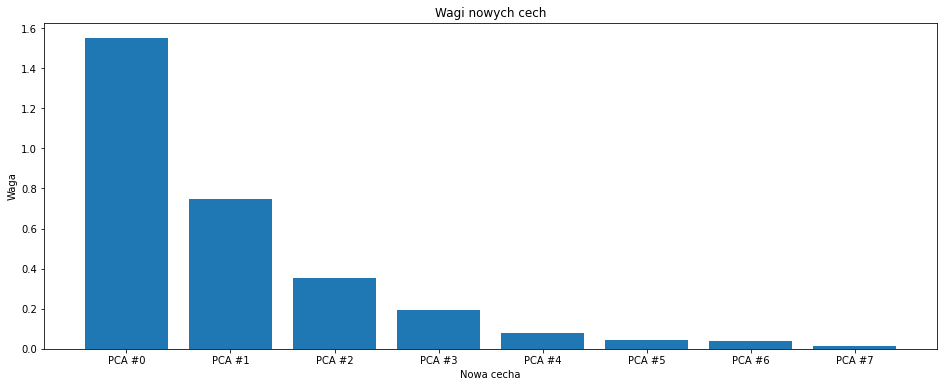

In [0]:
labels=['PCA #{}'.format(i) for i in range(to_keep)]

fig = plt.figure(figsize=(to_keep * 2, 6))
plt.bar(labels, eigenvalues)
plt.xlabel("Nowa cecha")
plt.ylabel("Waga")
plt.title("Wagi nowych cech")

plt.show()

### Udział starych cech w nowych cechach

Prześledźmy jaki udział stare cechy mają w poszczególnych nowych cechach.


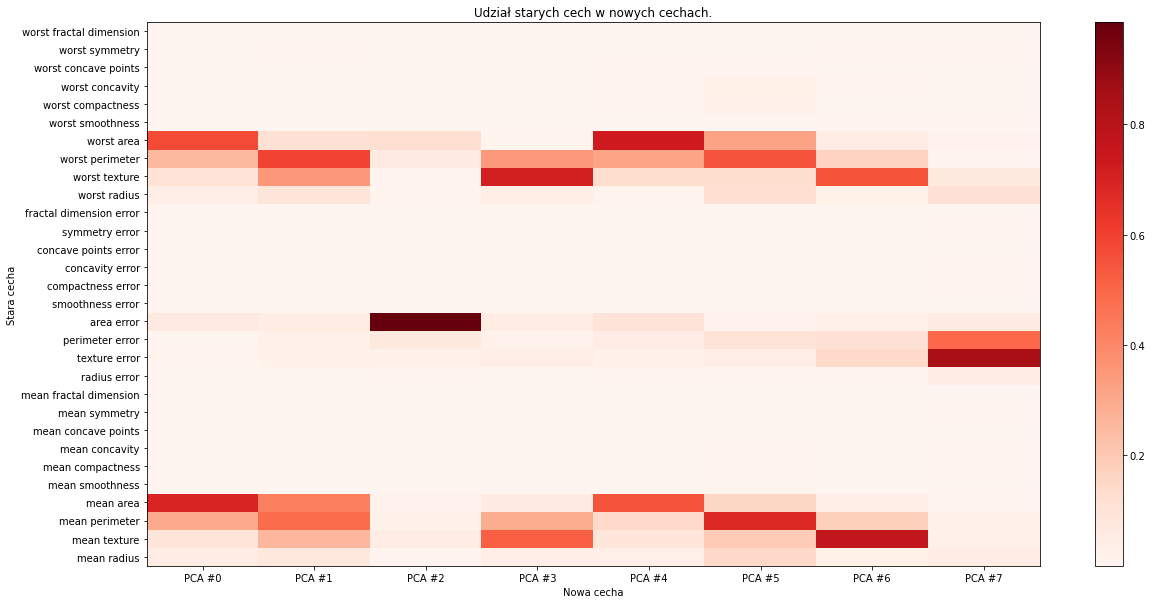

In [0]:
fig, ax = plt.subplots(figsize=(20,10))

heatmap = ax.pcolor(abs(pca.components_.transpose()), cmap='Reds')

fig.colorbar(heatmap)

ax.set_yticks(np.arange(pca.components_.shape[1])+0.5, minor=False)
ax.set_xticks(np.arange(pca.components_.shape[0])+0.5, minor=False)
ax.set_xticklabels(labels, minor=False)
ax.set_yticklabels(breast_cancer_ds.feature_names, minor=False)

plt.xlabel("Nowa cecha")
plt.ylabel("Stara cecha")
plt.title("Udział starych cech w nowych cechach.")
plt.show()

Z powyższego można wywnioskować, iż niektóre cechy np. *radius_error*, *mean_symmetry* czy *worst fractal dimension* nie wnoszą wiele do zbioru danych. Możemy więc z nich zrezygnować aby zredukować wymiar, możemy też użyć zestawu naszych nowych cech.

## Zadanie 5. KNN
*Zbadać jakość klasyfikatorów k-nn (dla różnego k=1,3,5)  dla pełnego zestawu N „starych”cech oraz N nowych cech. A także dla mniejszego zestawu m najlepszych „starych” cech  i dla wyselekcjonowanego  zestawu m „nowych” najlepszych cech (przy pomocy PCA). Przy pomocy studentów wypełnić tabelkę: (k=1,3,5; m=N,5,2) dla tych dwóch zbiorów.*

In [0]:
breast_cancer_ds = load_breast_cancer()

In [0]:
data = breast_cancer_ds['data'].copy()

print('Breast cancer data shape: ', data.shape)
normalized = normalize(data)

Breast cancer data shape:  (569, 30)


In [0]:
def with_m_most_important(data, target, m):
  model = ExtraTreesClassifier()
  model.fit(data, target)
  importance = model.feature_importances_

  most_important = list(map(lambda x: x[0], sorted(enumerate(importance), key = lambda x: x[1], reverse=True)[:m]))
  return data[:,most_important]


In [0]:
ks = [1,3,5]
features_count = normalized.shape[1]
ms = [features_count, 5, 2]

acc_pca = []
acc_etc = []

for k in ks:
  for m in ms:
    pca, pca_data = pca_transform(normalized, m)
    acc = predict_and_check_util(k, pca_data, breast_cancer_ds.target)
    acc_pca.append([k, m, acc])

    old_data = with_m_most_important(normalized, breast_cancer_ds.target, m)
    acc = predict_and_check_util(k, old_data, breast_cancer_ds.target)
    acc_etc.append([k, m, acc])

df = pd.DataFrame(acc_pca, columns=['k-neighbours', 'm-features', 'score'])
print('PCA scores:')
print(df)
print()

df = pd.DataFrame(acc_etc, columns=['k-neighbours', 'm-features', 'score'])
print('ETC scores:')
print(df)

PCA scores:
   k-neighbours  m-features     score
0             1          30  0.881579
1             1           5  0.894737
2             1           2  0.892544
3             3          30  0.890351
4             3           5  0.918860
5             3           2  0.903509
6             5          30  0.912281
7             5           5  0.899123
8             5           2  0.905702

ETC scores:
   k-neighbours  m-features     score
0             1          30  0.855263
1             1           5  0.907895
2             1           2  0.881579
3             3          30  0.903509
4             3           5  0.912281
5             3           2  0.901316
6             5          30  0.905702
7             5           5  0.899123
8             5           2  0.910088


Zauważmy, że PCA nie zawsze osiąga lepszy wynik niż wybór m najlepszych cech. Spójrzmy na heat-mapę (powyżej) udziału starych cech w nowych dla zestawu 'breast cancer'. Okazuje się, że jedynie około 9 starych cech ma jakiś udział w nowych cechach.

## Zadanie 6. PCA 2D
*Pokazać wizualizację zbioru danych przy pomocy PCA w 2 wymiarach. Na rysunku zaznaczyć przykłady żle sklasyfikowane i tzw. Outliery (znaleźć procedurę do poszukiwania outlierów!)*

Na początku redukcja datasetu do 2 wymiarów używająć PCA:

In [0]:
def set_plot(title, label1, label2):
  fig = plt.figure(figsize=(22, 14))
  ax = fig.add_subplot(111)

  ax.set_title(title)
  ax.set_xlabel(label1)
  ax.set_ylabel(label2)

  return ax

In [0]:
original_data, original_target = load_breast_cancer(return_X_y=True)
data, target = original_data.copy(), original_target.copy()

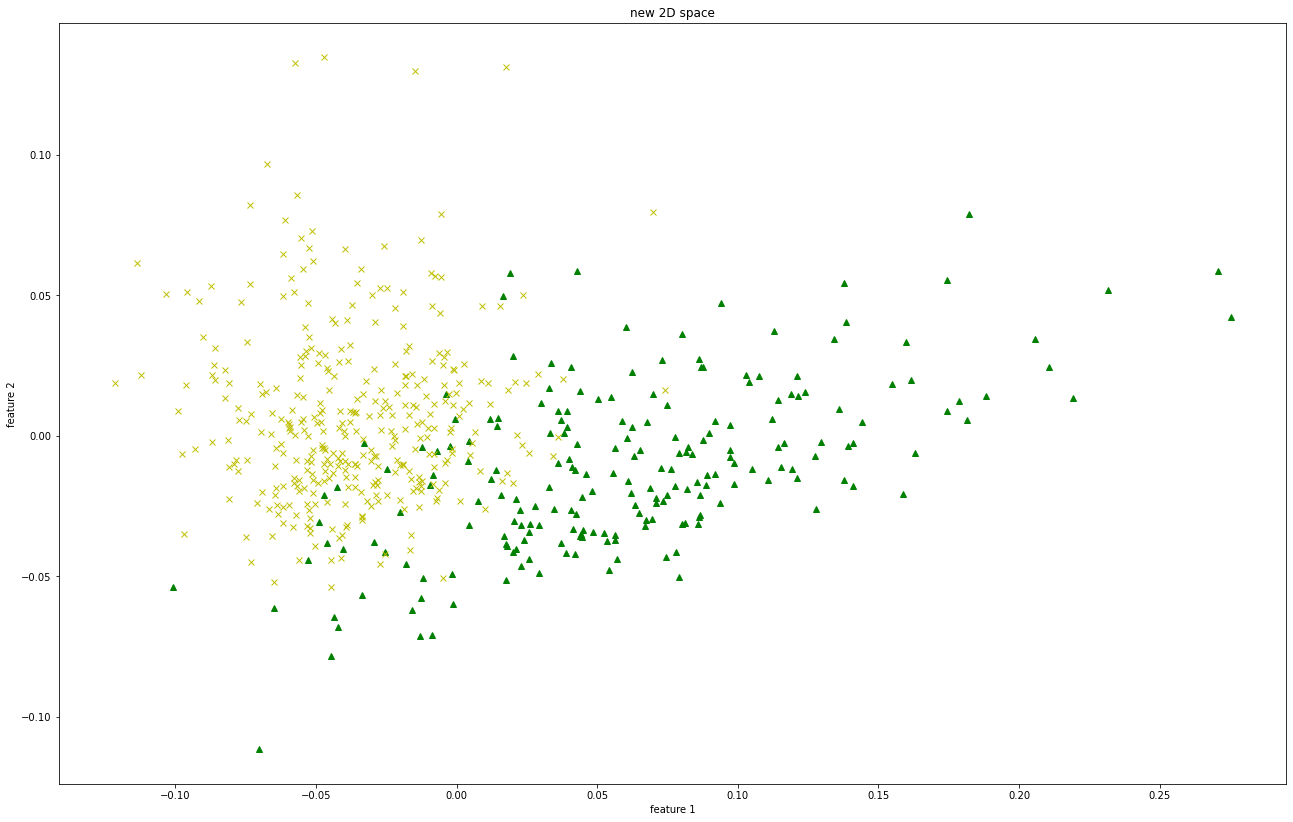

In [0]:
# Apply PCA
data = normalize(data)
pca = PCA(n_components=2)
new_data = pca.fit_transform(data)

# Split into targets, to visualise it better
malignant = new_data[np.where(target == 0)]
benign = new_data[np.nonzero(target)]

# Plotting
ax = set_plot('new 2D space', 'feature 1', 'feature 2')

x, y = malignant[:,0], malignant[:,1]
ax.plot(x, y, 'g^')
x, y = benign[:,0], benign[:,1]
ax.plot(x, y, 'yx')

plt.show()

There are: 35 wrongly classified points, that is 6.151142355008787%


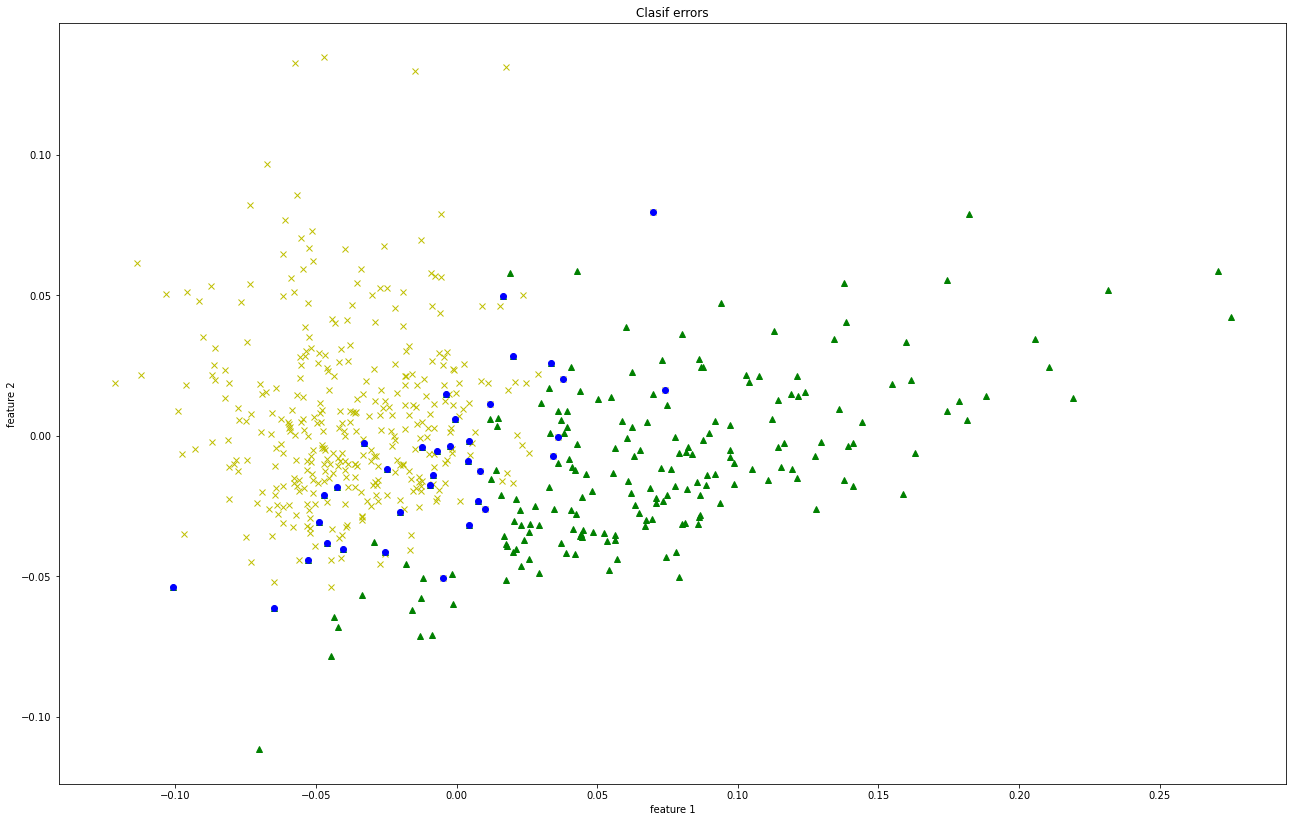

In [0]:
# Find wrongly classified points
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(new_data, target)
prediction = neigh.predict(new_data)

wrong_pred = target - prediction
wrong_points = new_data[np.where(wrong_pred != 0)]

print('There are: {} wrongly classified points, that is {}%'.
      format(wrong_points.shape[0], (wrong_points.shape[0] / target.shape[0] * 100))
      )

# Plotting wrongly classified points
ax = set_plot('Clasif errors', 'feature 1', 'feature 2')

x, y = malignant[:,0], malignant[:,1]
ax.plot(x, y, 'g^')
x, y = benign[:,0], benign[:,1]
ax.plot(x, y, 'yx')
x, y = wrong_points[:,0], wrong_points[:,1]
ax.plot(x, y, 'bo') # wrongly classified points marked in blue circles

plt.show()


### **Detekcja outlierów**

Problem detekcji outlierów polega na tym, że mamy sklasyfikować dane punkty jako należące do pewnej "standardowej dystrybucji danych" (jakakolwiek dla danego zbioru danych by nie była) lub do niej nienależące. Jest wiele algorytmów dla rozwiązań tego problemu.

Przykłady:

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_anomaly_comparison_0011.png)
https://scikit-learn.org/stable/_images/sphx_glr_plot_anomaly_comparison_0011.png


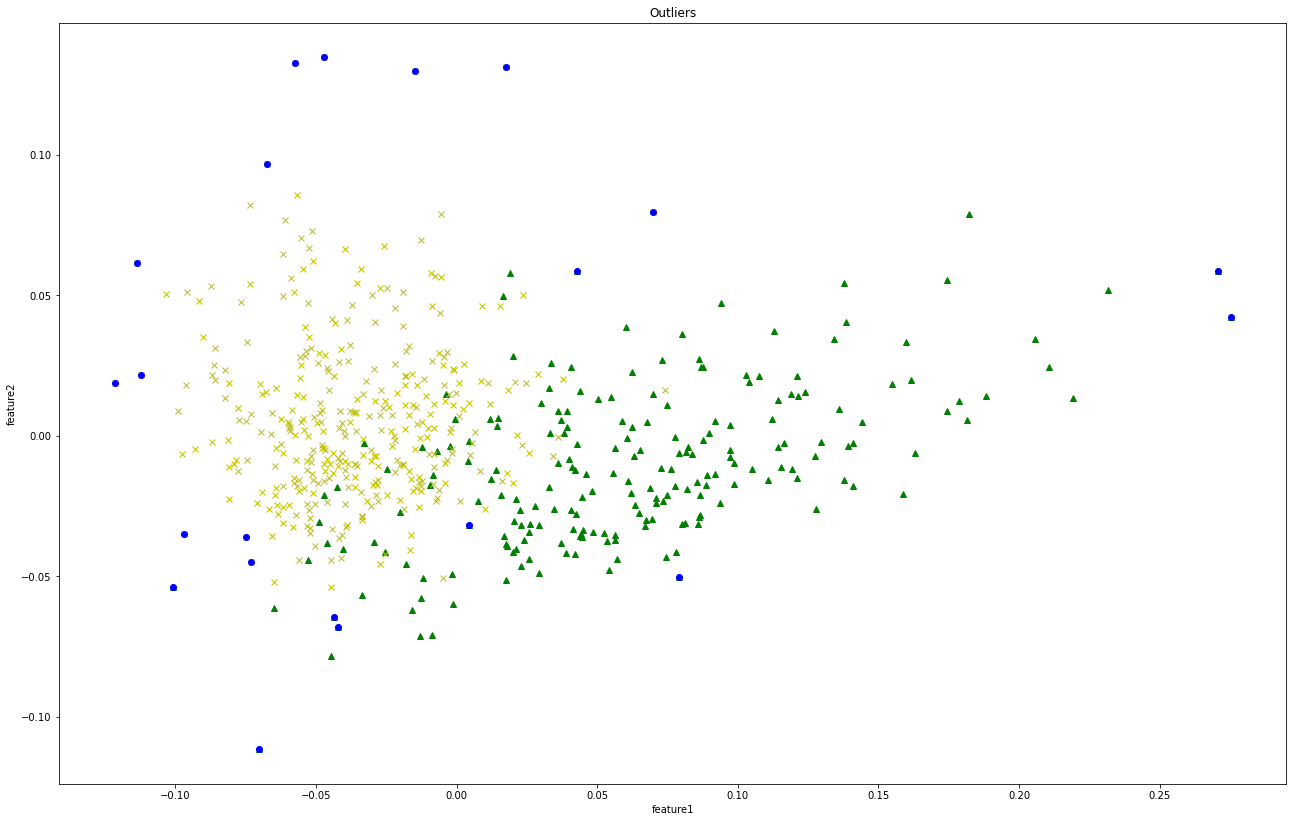

In [0]:
# Outlier prediction using local classifier
clf = LocalOutlierFactor(n_neighbors=8)
labels = clf.fit_predict(new_data)

outliers = new_data[np.where(labels == -1)]

# Plotting
ax = set_plot('Outliers', 'feature1', 'feature2')

x, y = malignant[:,0], malignant[:,1]
ax.plot(x, y, 'g^')
x, y = benign[:,0], benign[:,1]
ax.plot(x, y, 'yx')
x, y = outliers[:,0], outliers[:,1]
ax.plot(x, y, 'bo') # outliers marked in blue circles


plt.show()


## Zadanie 7.
*ZADANIE: W zbiorach MNIST, FMNIST, CIFAR-10 . Do dalszych eksperymentów wybraćilość przykładów nie większy niż M=2xN !!!(N- ilość cech).*


### a. Najmniej informatywne piksele

Znaleźć NAJMNIEJ INFORMATYWNE cechy (piksele). Zobrazować je na rysunku, wielkością odpowiadającemu klasyfikowanym obrazkom.


### b. Klasyfikacja k-nn

Dokonać klasyfikacji k-nn na pełnym zbiorze i zbiorze bez m najmniej informatywnych cech.

### c. Transformacja PCA

Przetransformować zbiory przy pomocy PCA z N-D do N-D. Jak wyglądają(obrazki) wektory własne odpowiadające największym wartościom własnym. Sprawdzić, czy poprawił się wynik klasyfikacji. Dokonać wizualizacji 2-D przy pomocy PCA.

### d. Redukcja wymiaru

Usunąć m najmniej informatywnych cech PCA. Jak wygląda wynik klasyfikacji.

### e. Wybór najlepszych cech
Wybrac m NAJLEPSZYCH cech PCA. Jak wygląda teraz wynik klasyfikacji.
Wartość m w przypadku wyboru najgorszych cech ma być duże (dla N=784 jakieś m=500), w przypadku wyboru najlepszych małe (m=10-20)

### f. PCA z Imgaug
Dokonać klasyfikacji z PCA i bez PCA (na pełnym zbiorze cech i zadanym małym M), ale zwiększając ilość przykładów przy pomocy augmentacji (imgaug).

 ### h.Wnioski
 (co lepsze augmentacja czy inżynieria cech?)